In [1]:
import matplotlib.pyplot as plt

import boa
from l6 import lesson6, user_balances, vault_summary

user = boa.env.eoa
vault, controller, amm, oracle, liquidity_pool, collateral_token, crvusd = lesson6()

# Sanity check
print(f"Number of loans in the `{controller._name}` vault: {controller.n_loans()}")

Number of loans in the `VyperWifController` vault: 1


In [2]:
def plot(amm, user):
    bands = range(
        min(0, amm.active_band(), amm.read_user_tick_numbers(user)[0]),
        max(amm.active_band(), amm.read_user_tick_numbers(user)[1]) + 1,
    )

    p_min = [amm.p_oracle_down(n) for n in bands]
    p_max = [amm.p_oracle_up(n) for n in bands]
    y_values = [amm.bands_y(n) for n in bands]

    fig, ax = plt.subplots(figsize=(12, 6))
    grey_cmap = plt.colormaps["Greys"]

    for i, (min_val, max_val, y_val) in enumerate(zip(p_min, p_max, y_values)):
        width = max_val - min_val

        if bands[i] == amm.active_band():
            color = "green"
            edge_color = "darkgreen"
        else:
            # Use different shades of grey for non-active bands
            color = grey_cmap(0.3 + (i / len(bands)) * 0.5)
            edge_color = grey_cmap(0.5 + (i / len(bands)) * 0.5)

        rect = plt.Rectangle(
            (min_val, 0),
            width,
            y_val,
            fill=True,
            facecolor=color,
            alpha=0.3,
            edgecolor=edge_color,
            linewidth=0.5,
        )
        ax.add_patch(rect)

        # Add horizontal line for y_val = 0 cases
        ax.plot([min_val, max_val], [y_val, y_val], color=edge_color, linewidth=2)

    # Price line
    ax.axvline(
        x=oracle.price(), color="red", linestyle="-", linewidth=2, label="Oracle Price"
    )
    ax.axvline(
        x=amm.price_oracle(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label="AMM Price",
    )

    # Lavels
    ax.set_xlabel("Price (p)")
    ax.set_ylabel("Collateral")
    ax.set_title(f"Price Range and Collateral for User {user}")
    ax.legend()

    # Plot
    ax.set_ylim(bottom=0)
    ax.set_xlim(0.74 * 10**18, 1.01 * 10**18)
    plt.tight_layout()
    plt.show()

# Initial State

In [3]:
# Initial balances
print("Starting Conditions:")
user_balances(user, crvusd, collateral_token)

# Status Report
vault_summary(oracle, controller, amm)

Starting Conditions:

BALANCES FOR 0x00dE89C733555886f785b0C32b498300297e481F
• crvUSD:	78,715.53
• Collateral:	89,900,000

VAULT SUMMARY `VyperWifController`
• Oracle Price:		1.00
• AMM Price:		1.00
• Users to Liquidate:	0
• Number of Loans:	1


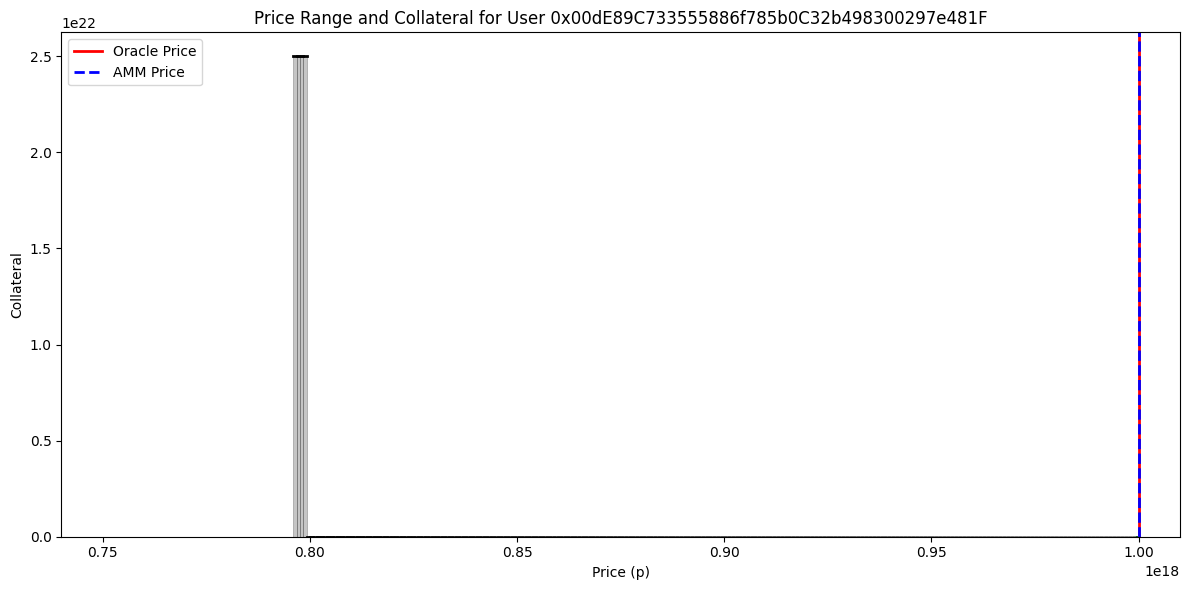

In [4]:
plot(amm, user)

# Price Nuke

In [5]:
# Price drops 25%
new_price = int(0.75 * oracle.price())
oracle.set_price(new_price)

# Status Report
vault_summary(oracle, controller, amm)


VAULT SUMMARY `VyperWifController`
• Oracle Price:		0.75
• AMM Price:		0.80
• Users to Liquidate:	0
• Number of Loans:	1


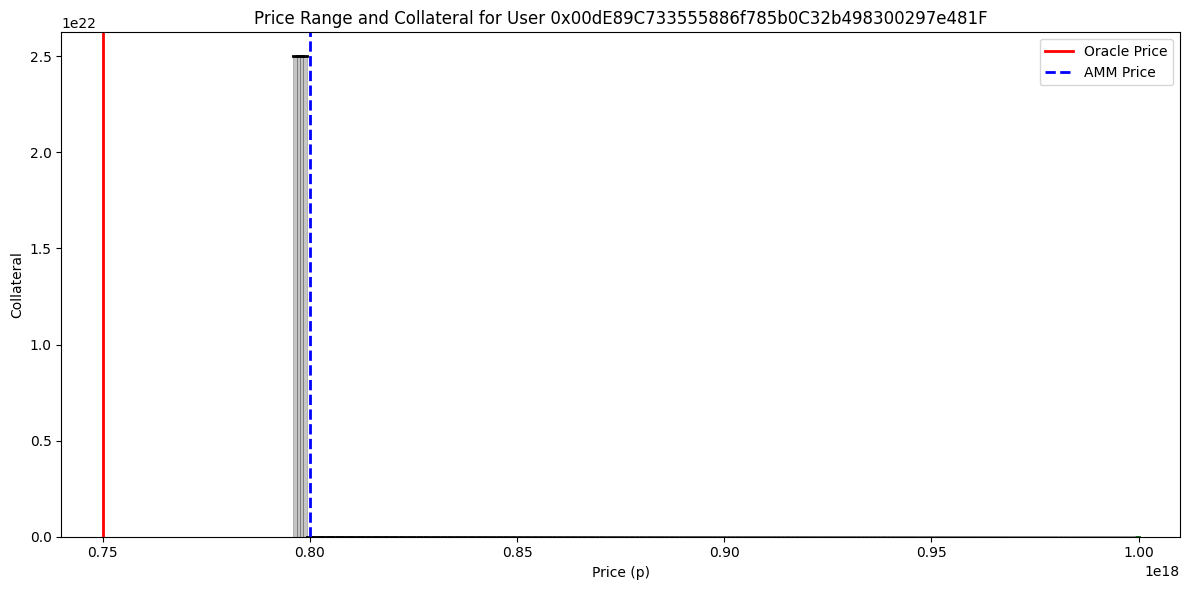

In [6]:
plot(amm, user)

# Time Passes

In [7]:
# Time Travel
# XXX

# Status Report
vault_summary(oracle, controller, amm)


VAULT SUMMARY `VyperWifController`
• Oracle Price:		0.75
• AMM Price:		0.75
• Users to Liquidate:	1
• Number of Loans:	1


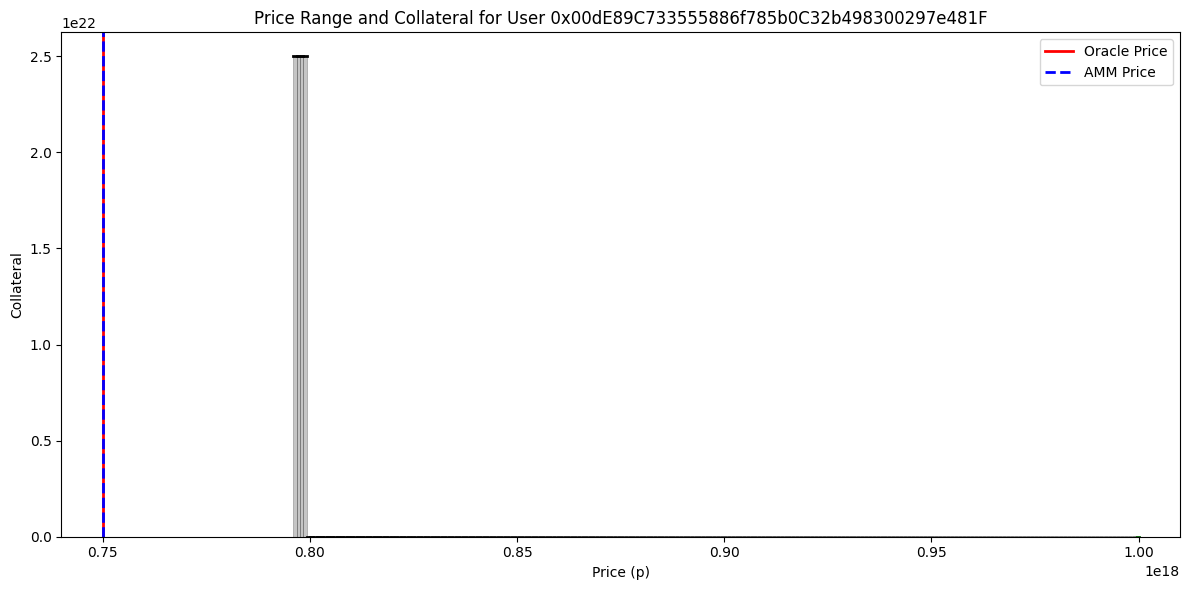

In [8]:
plot(amm, user)

# Self Liquidation

In [9]:
# How much do we need to liquidate
liquidation_amount = # XXX
needed_amount = liquidation_amount - crvusd.balanceOf(boa.env.eoa)

print(f"Need {liquidation_amount / 10 ** 18 :.3f} $crvUSD to liquidate")
print(f"Difference is {needed_amount / 10 ** 18:.3f}")

user_balances(user, crvusd, collateral_token)

Need 78715.555 $crvUSD to liquidate
Difference is 0.022

BALANCES FOR 0x00dE89C733555886f785b0C32b498300297e481F
• crvUSD:	78,715.53
• Collateral:	89,900,000


In [10]:
# Get Liquidation Amount
token_amount = # XXX 
print(f"Looks like {token_amount}")

while liquidity_pool.get_dy(1, 0, token_amount) < needed_amount:
    token_amount = int(token_amount * (1.0000000000001))
    print(f"Adjusting to {token_amount}")

Looks like 21840350438510740
Adjusting to 21840350438512924
Adjusting to 21840350438515108


In [11]:
# Exchange for Liquidation Amount
if collateral_token.allowance(boa.env.eoa, liquidity_pool) < token_amount:
    collateral_token.approve(liquidity_pool, token_amount)

liquidity_pool.exchange(1, 0, token_amount, needed_amount)

# Liquidate
liquidate_amount = controller.tokens_to_liquidate(boa.env.eoa)
assert crvusd.balanceOf(boa.env.eoa) >= liquidate_amount, "Not enough tokens"

crvusd.approve(controller, liquidate_amount)
# XXX

# Final Status Report
user_balances(user, crvusd, collateral_token)
vault_summary(oracle, controller, amm)


BALANCES FOR 0x00dE89C733555886f785b0C32b498300297e481F
• crvUSD:	0.00
• Collateral:	90,000,000

VAULT SUMMARY `VyperWifController`
• Oracle Price:		0.75
• AMM Price:		0.75
• Users to Liquidate:	0
• Number of Loans:	0
